### Main file for calibration ###

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import function as f
from scipy.signal import find_peaks
from NewCalibration import Calib_position
from NewCalibration import Calib_energy
from NewCalibration import Calib_channel

In [ ]:

# this part handles the balistic calibration

lower_bound = [3500, 3500, 3500, 3500, 3500, 3450, 3450, 3400, 3500, 3500, 3500, 3500, 3550, 3500, 3450] # seen from plot_data
upper_bound = [3750, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3800, 3800, 3700, 3700]

# tabulated energies of the alpha particles

energy1 = 5156.59 
energy2 = 5485.46
energy3 = 5804.77


thres= [20, 20, 20, 20, 20, 15, 20, 15, 15, 30, 15, 15, 15, 10, 15, 20] # threshold for selecting relevant counts


for ii in range(1,16):
    file = "20240808_test001_0001_uncal.txt"
    strip = ii
    my_cal = Calib_position("Strippos", "Energy")
    my_cal.read_data(file)
    my_cal.plot_hist(strip)
    my_cal.plot_data(strip, thres[ii-1])
    my_cal.fit_data(strip, lower_bound[ii-1], upper_bound[ii-1]) 
    #my_cal.fit_results()
    #my_cal.write_txt('fit_results', strip, energy1, energy2, energy3)
    my_cal.plot_calib_hist(lower_bound[ii-1], upper_bound[ii-1], strip, energy1, energy2, energy3)

In [ ]:
# This part handles the energy calibration

for ii in range(1,16):
    if ii<10:
        file = '16 Strip Position Corrected Energy 0'+str(ii)+'.hdat'
        strip = '0'+str(ii)
    else:
        file = '16 Strip Position Corrected Energy '+str(ii)+'.hdat'
        strip = str(ii)
    my_en = Calib_energy("# X ", "Content")
    my_en.read_data(file)
    my_en.plot_hist(strip)
    my_en.initial_guess()
    my_en.fit_gauss(strip)
    #my_en.write_txt('gauss_results', strip)


In [ ]:
# This part handles the conversion between energy and channel

energy1 = 5156.59
energy2 = 5485.46
energy3 = 5804.77

for ii in range(1,16):
    if ii<10:
        file = 'gauss_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        file = 'gauss_results'+str(ii)+'.dat'
        strip = str(ii)

    my_channel = Calib_channel(energy1, energy2, energy3)
    my_channel.read_txt(file)
    my_channel.fit_line(strip)
    #my_channel.write_txt('line_results', strip)

In [2]:
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, 'results')
'''
m = []
q = []

path = os.path.join(work_dir, 'Calib_energy_chiara.dat')
text=open(path, 'w')

for ii in range(1,16):
    if ii<10:
        filename = 'line_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        filename = 'line_results'+str(ii)+'.dat'
        strip = str(ii)

    filepath = os.path.join(data_dir, filename)
    m_i, q_i = np.loadtxt(filepath, comments='#', unpack=True)
    print('%.3f %.3f' % (m_i, q_i), file=text)


text.close()
'''

"\nm = []\nq = []\n\npath = os.path.join(work_dir, 'Calib_energy_chiara.dat')\ntext=open(path, 'w')\n\nfor ii in range(1,16):\n    if ii<10:\n        filename = 'line_results0'+str(ii)+'.dat'\n        strip = '0'+str(ii)\n    else:\n        filename = 'line_results'+str(ii)+'.dat'\n        strip = str(ii)\n\n    filepath = os.path.join(data_dir, filename)\n    m_i, q_i = np.loadtxt(filepath, comments='#', unpack=True)\n    print('%.3f %.3f' % (m_i, q_i), file=text)\n\n\ntext.close()\n"

353426
353426


(4800.0, 5800.0)

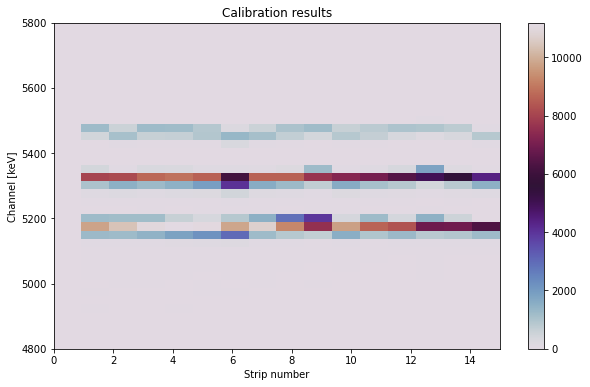

In [33]:

filename = "20240808_test001_0001_uncal.txt"
filepath = os.path.join(work_dir, filename)
my_df = pd.read_csv(filepath, sep=" ", header=0) 


position = my_df['Strippos'].to_numpy()
energy = my_df['Energy'].to_numpy()
strip = my_df['Stripnum'].to_numpy()



calib_position = "Calib_position_chiara.dat"
pos_path = os.path.join(work_dir, calib_position)
a,b,c = np.loadtxt(pos_path, unpack=True)

calib_energy = 'Calib_energy_chiara.dat'
en_path = os.path.join(work_dir, calib_energy)
m,q = np.loadtxt(en_path, unpack=True)

corrected_energy=[]
corrected_strip=[]

for ii in range(0,16):
        index = my_df['Stripnum'].loc[my_df['Stripnum'] == ii].index
        strip_energy = energy[index]
        strip_position = position[index]
        strip_number = strip[index]
        energy_sel = strip_energy[strip_energy!=0] 
        position_sel = strip_position[strip_energy!=0]
        strip_sel = strip_number[strip_energy!=0]
        for jj in range(len(energy_sel)):
                delta_E = a[ii]*position_sel[jj]**2 + b[ii]*position_sel[jj] + c[ii]
                energy_corr = energy_sel[jj] - delta_E
                energy_fin = m[ii]*energy_corr + q[ii]
                corrected_energy.append(energy_fin)
                corrected_strip.append(ii)


print(len(corrected_energy))
print(len(corrected_strip))


plt.figure(figsize=(10,6))
plt.hist2d(corrected_strip, corrected_energy, bins=(16,500), cmap='twilight')
plt.colorbar()
plt.xlabel('Strip number')
plt.ylabel('Channel [keV]')
plt.title('Calibration results')
plt.ylim(4800,5800)